# Promptfoo: classification evaluations

**Note: This lesson lives in a folder that contains relevant code files. Download the entire folder if you want to follow along and run the evaluation yourself**


In an earlier lesson, we evaluated prompts to classify customer complains like: 

> Whenever I open your app, my phone gets really slow

and 

> I can't figure out how to change my password

into five different categories:
- Software Bug
- Hardware Malfunction
- User Error
- Service Outage
- Feature Request

In this lesson we'll port this prompt evaluation over to promptfoo, making it easier to batch-run and compare our results. 

---


## Initializing promptfoo

The first step is to initialize promptfoo using the command:

```bash
npx promptfoo@latest init
```

As we saw in the previous lesson, this creates a `promptfooconfig.yaml` file.  We can delete the existing contents. 

Next, we'll configure our provider.  Add the following to `promptfooconfig.yaml`:


```yaml
description: "Complaint Classification Eval"
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"
```

We'll use Claude 3 Haiku to save on API costs, since we'll be running this evaluation multiple times throughout this lesson.

**Ensure you have set the `ANTHROPIC_API_KEY` environment variable. You can set an environment variable by running this command in your terminal:**

```bash
export ANTHROPIC_API_KEY=your_api_key_here
```

---

## Preparing our prompts

Next, we'll collect our prompts and make sure promptfoo knows about them.  We'll follow the same pattern we saw in the previous video: 

- We'll make each prompt a Python function.
- Each prompt function will return a prompt string.
- All of our prompt functions will live in a `prompts.py` file.  

Create a new file called `prompts.py` and add the following prompt functions to the file.  There are the same two prompts we wrote in the original complaint classification lesson:


```py
def basic_prompt(complaint):
    return f"""
    Classify the following customer complaint into one or more of these categories: 
    Software Bug, Hardware Malfunction, User Error, Feature Request, or Service Outage.
    Only respond with the classification.

    Complaint: {complaint}

    Classification:
    """

def improved_prompt(complaint):
    return f"""
    You are an AI assistant specializing in customer support issue classification. Your task is to analyze customer complaints and categorize them into one or more of the following categories:

    1. Software Bug: Issues related to software not functioning as intended.
    2. Hardware Malfunction: Problems with physical devices or components.
    3. User Error: Difficulties arising from user misunderstanding or misuse.
    4. Feature Request: Suggestions for new functionalities or improvements.
    5. Service Outage: System-wide issues affecting service availability.

    Important Guidelines:
    - A complaint may fall into multiple categories. If so, list all that apply but try to prioritize picking a single category when possible.

    Examples:
    1. Complaint: "The app crashes when I try to save my progress."
    Classification: Software Bug

    2. Complaint: "My keyboard isn't working after I spilled coffee on it."
    Classification: Hardware Malfunction

    3. Complaint: "I can't find the login button on your website."
    Classification: User Error

    4. Complaint: "It would be great if your app had a dark mode."
    Classification: Feature Request

    5. Complaint: "None of your services are loading for me or my colleagues."
    Classification: Service Outage

    6. Complaint "Complaint: The app breaks every time I try to change my profile picture"
    Classification: Software Bug

    7. Complaint "The app is acting buggy on my phone and it seems like your website is down, so I'm completely stuck!"
    Classification: Software Bug, Service Outage

    8. Complaint: "Your software makes my computer super laggy and awful, I hate it!"
    Classification: Software Bug

    9. Complaint: "Your dumb app always breaks when I try to do anything with images."
    Classification: 'Software Bug'

    Now, please classify the following customer complaint:

    <complaint>{complaint}</complaint>

    Only respond with the appropriate categories and nothing else.
    Classification:
    """
```


Next, we need to tell promptfoo we want to use these two prompts.  Update the `promptfooconfig.yaml` file: 

```yaml
description: "Complaint Classification Eval"

prompts:
  - prompts.py:basic_prompt
  - prompts.py:improved_prompt
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"
```

---


## Preparing our evaluation test set

The final step is to get our evaluation data set into a shape that plays well with promptfoo.  As a reminder, this is what our original `eval_data` Python list from the earlier lesson looked like:

```py
eval_data = [
    {
        "complaint": "The app crashes every time I try to upload a photo",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "My printer isn't recognized by my computer",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "I can't figure out how to change my password",
        "golden_answer": ["User Error"]
    },
    {
        "complaint": "The website is completely down, I can't access any pages",
        "golden_answer": ["Service Outage"]
    },
    {
        "complaint": "It would be great if the app had a dark mode option",
        "golden_answer": ["Feature Request"]
    },
    {
        "complaint": "The software keeps freezing when I try to save large files",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "My wireless mouse isn't working, even with new batteries",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "I accidentally deleted some important files, can you help me recover them?",
        "golden_answer": ["User Error"]
    },
    {
        "complaint": "None of your servers are responding, is there an outage?",
        "golden_answer": ["Service Outage"]
    },
    {
        "complaint": "Could you add a feature to export data in CSV format?",
        "golden_answer": ["Feature Request"]
    },
    {
        "complaint": "The app is crashing and my phone is overheating",
        "golden_answer": ["Software Bug", "Hardware Malfunction"]
    },
    {
        "complaint": "I can't remember my password!",
        "golden_answer": ["User Error"]
    },
    {
        "complaint": "The new update broke something and the app no longer works for me",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "I think I installed something incorrectly, now my computer won't start at all",
        "golden_answer": ["User Error", "Hardware Malfunction"]
    },
    {
        "complaint": "Your service is down, and I urgently need a feature to batch process files",
        "golden_answer": ["Service Outage", "Feature Request"]
    },
    {
        "complaint": "The graphics card is making weird noises",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "My keyboard just totally stopped working out of nowhere",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "Whenever I open your app, my phone gets really slow",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "Can you make the interface more user-friendly? I always get lost in the menus",
        "golden_answer": ["Feature Request", "User Error"]
    },
    {
        "complaint": "The cloud storage isn't syncing and I can't access my files from other devices",
        "golden_answer": ["Software Bug", "Service Outage"]
    }
]
```

As we did in the previous lesson, we'll turn our data set into a CSV file.  The key difference here is that our evaluation logic is no longer a simple exact-match.  In order to grade this evaluation, we want promptfoo to make sure that each model output includes the correct classification(s)

For example, given this row from the dataset:

```py
{
    "complaint": "The cloud storage isn't syncing and I can't access my files from other devices",
    "golden_answer": ["Software Bug", "Service Outage"]
}
```

We'll write a prompt that takes this input `complaint`:

>The cloud storage isn't syncing and I can't access my files from other devices

For the above example, we need promptfoo to ensure that the model's response includes "Software Bug" and "Service Outage". We can't do an exact match. What if the model switches the output order of the two classifications?  Thankfully, promptfoo includes a bunch of built-in assertions that we can take advantage of.  These assertions include things like: 

* `contains` - output contains substring
* `contains-all` - output contains all list of substrings
* `contains-any` - output contains any of the listed substrings
* `contains-json` - output contains valid json (optional json schema validation)
* `contains-sql` - output contains valid sql
* `contains-xml`- output contains valid xml
* `equals` - output matches exactly
* `icontains` - output contains substring, case insensitive
* `icontains-all` - output contains all list of substrings, case insensitive
* `icontains-any` - output contains any of the listed substrings, case insensitive
* `regex`	- output matches regex
* many others

[View an exhaustive list of built-in metrics here.](https://www.promptfoo.dev/docs/configuration/expected-outputs/deterministic/)

For our use-case, we'll use `contains-all` to ensure that a given output contains all of the appropriate classification tags.  

One way of loading and structuring a promptfoo evaluation dataset is through CSV.  As we saw previously, we can provide a special CSV column name called `__expected` to specify grading logic.  In this column we can use any of the above built-in assertions, including `contains-all`


Make a new file called `dataset.csv` and paste this code into it: 

```csv
complaint,__expected
The app crashes every time I try to upload a photo,contains-all:Software Bug
My printer isn't recognized by my computer,contains-all:Hardware Malfunction
I can't figure out how to change my password,contains-all:User Error
The website is completely down I can't access any pages,contains-all:Service Outage
It would be great if the app had a dark mode option,contains-all:Feature Request
The software keeps freezing when I try to save large files,contains-all:Software Bug
My wireless mouse isn't working even with new batteries,contains-all:Hardware Malfunction
I accidentally deleted some important files can you help me recover them?,contains-all:User Error
None of your servers are responding is there an outage?,contains-all:Service Outage
Could you add a feature to export data in CSV format?,contains-all:Feature Request
"The app is crashing and my phone is overheating","contains-all:Software Bug,Hardware Malfunction"
I can't remember my password!,contains-all:User Error
The new update broke something and the app no longer works for me,contains-all:Software Bug
"I think I installed something incorrectly now my computer won't start at all","contains-all:User Error,Hardware Malfunction"
"Your service is down and I urgently need a feature to batch process files","contains-all:Service Outage,Feature Request"
The graphics card is making weird noises,contains-all:Hardware Malfunction
My keyboard just totally stopped working out of nowhere,contains-all:Hardware Malfunction
Whenever I open your app my phone gets really slow,contains-all:Software Bug
Can you make the interface more user-friendly? I always get lost in the menus,"contains-all:Feature Request,User Error"
The cloud storage isn't syncing and I can't access my files from other devices,"contains-all:Software Bug,Service Outage"
```

Our CSV contains two columns:
- `complaint` - the actual input complains
- `__expected` - contains a `contains-all` assertion

Take a look at one of the rows, like this one:

> "Your service is down and I urgently need a feature to batch process files","contains-all:Service Outage,Feature Request"

This row of the dataset specifies that given the input "Your service is down and I urgently need a feature to batch process files," we want promptfoo to check the model's output and ensure it includes both "Service Outage" and "Feature Request"


The final step here is to update our `promptfooconfig.yaml` file to include the tests we just wrote.  The file should now look like this:

```yaml
description: "Complaint Classification Eval"

prompts:
  - prompts.py:basic_prompt
  - prompts.py:improved_prompt
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"

tests: dataset.csv

```

---

## Running the evaluation

To run the evaluation, we'll use the same command we've seen before:

```bash
npx promptfoo@latest eval
```

This is the output we got the first time we ran the above eval: 

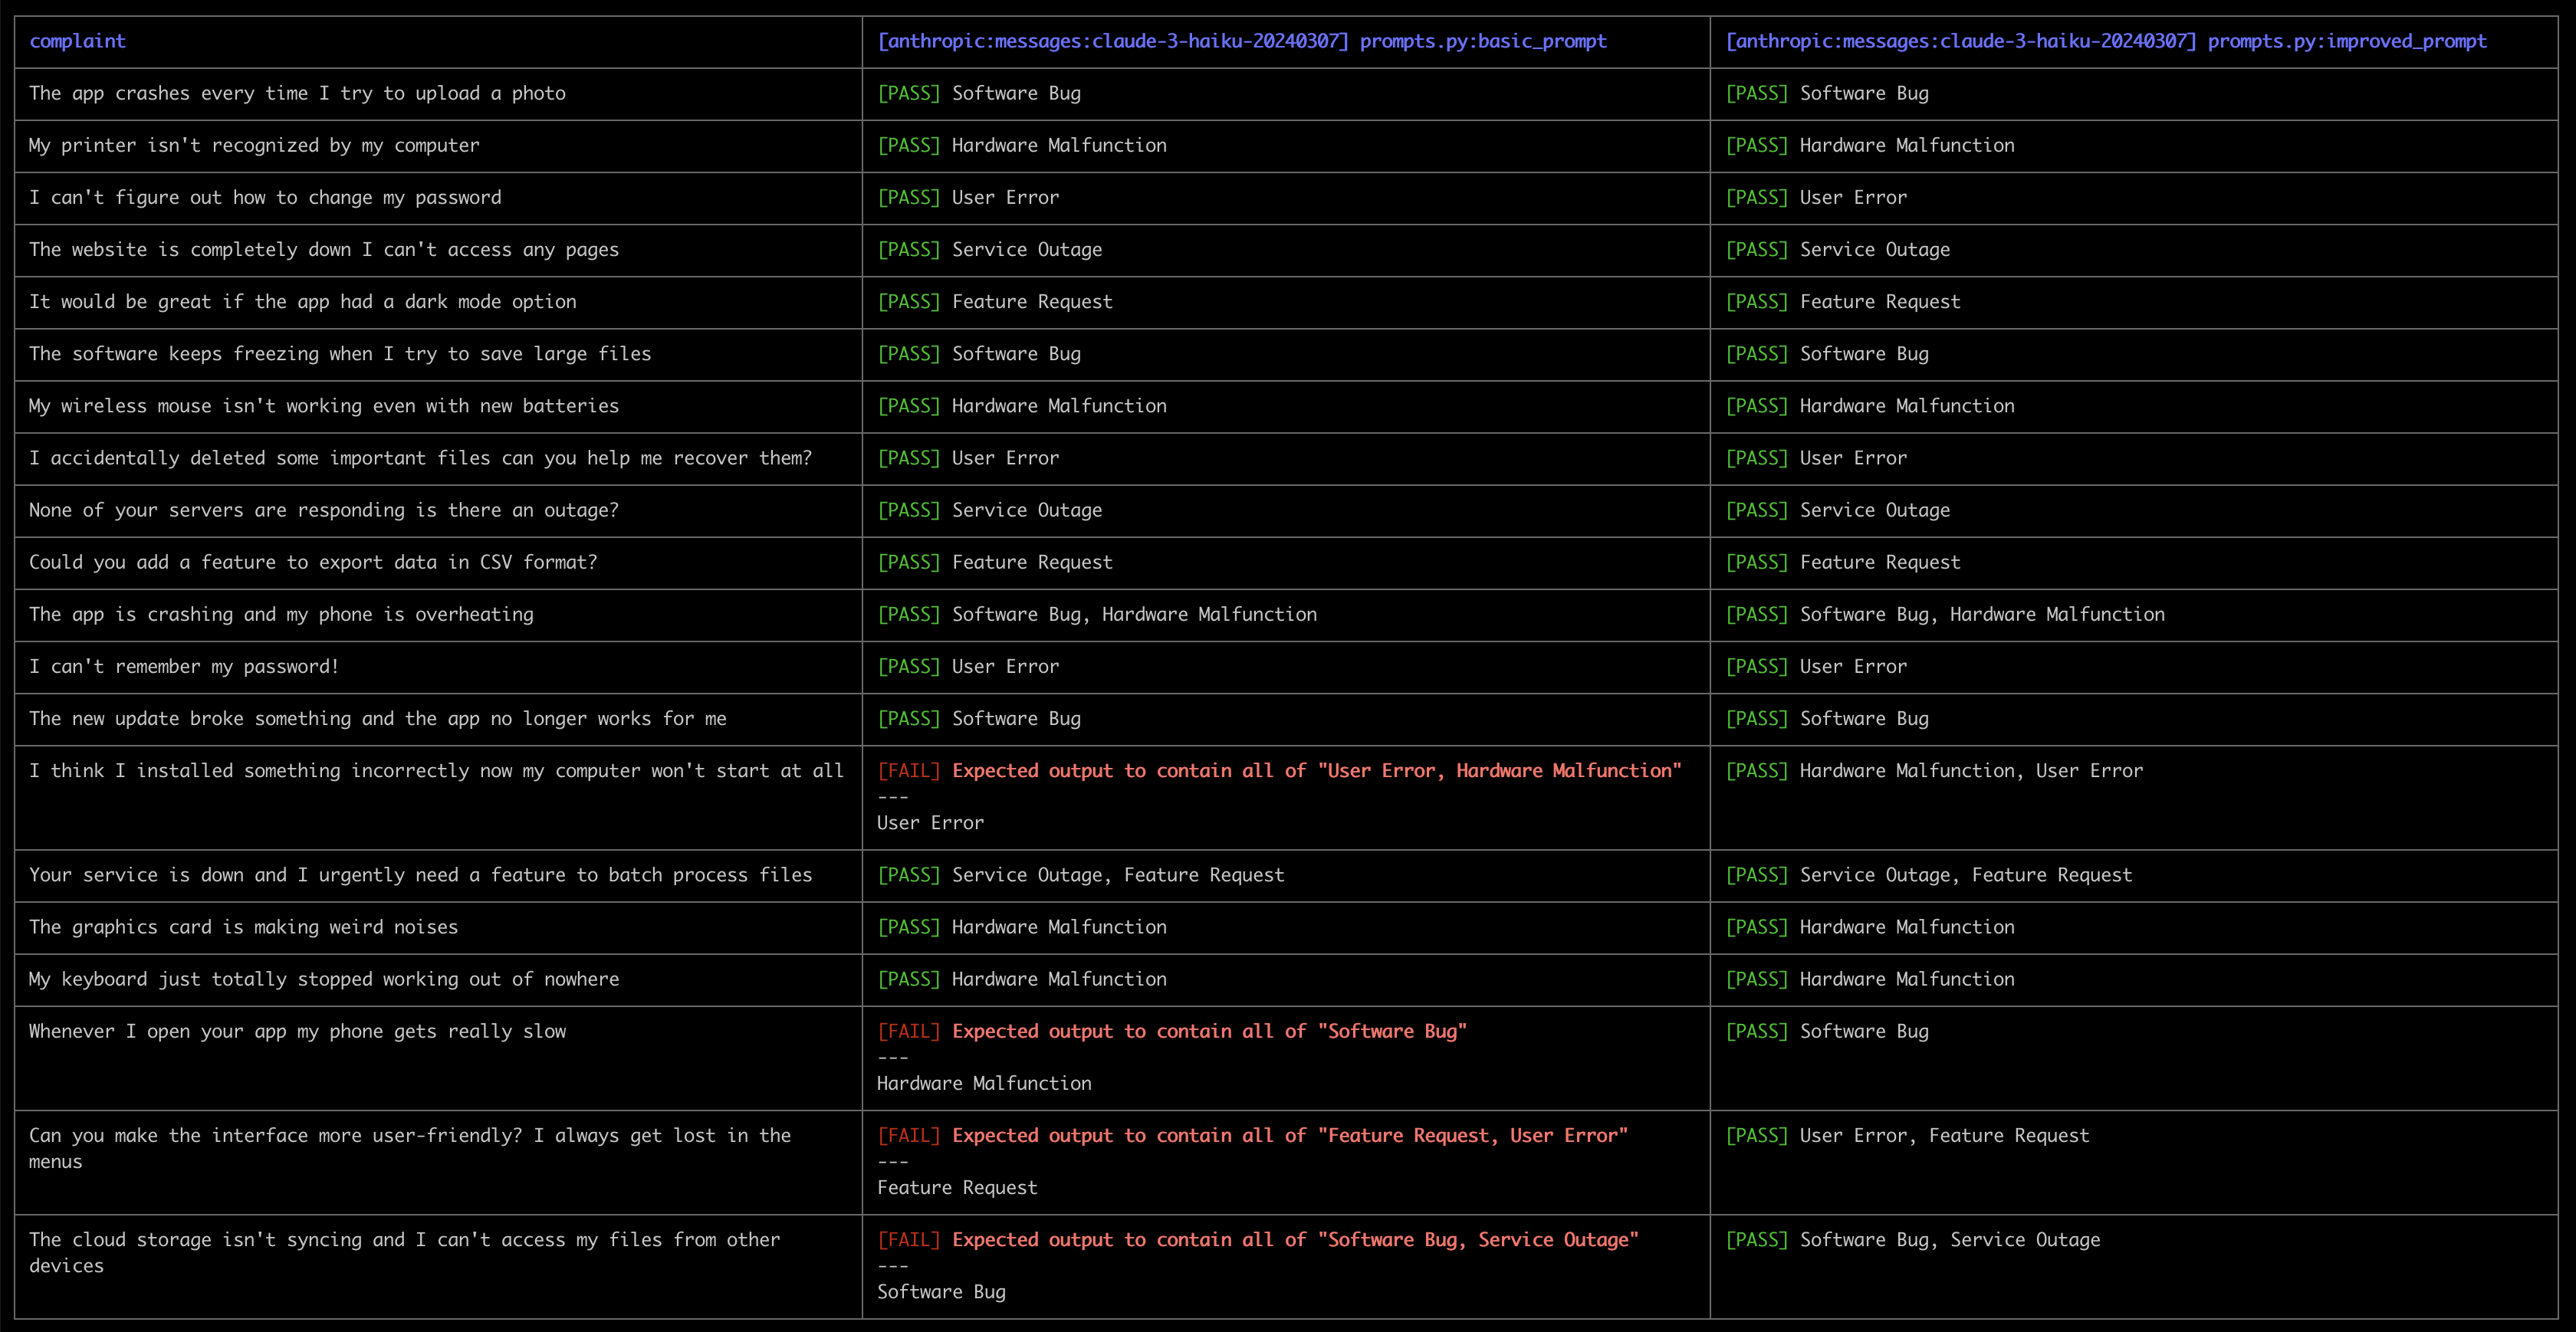

It's clear that the improved prompt that includes examples performs better than our initial basic prompt.  The examples help the model understand the types of situations we may want the output to include multiple categories assigned to it:

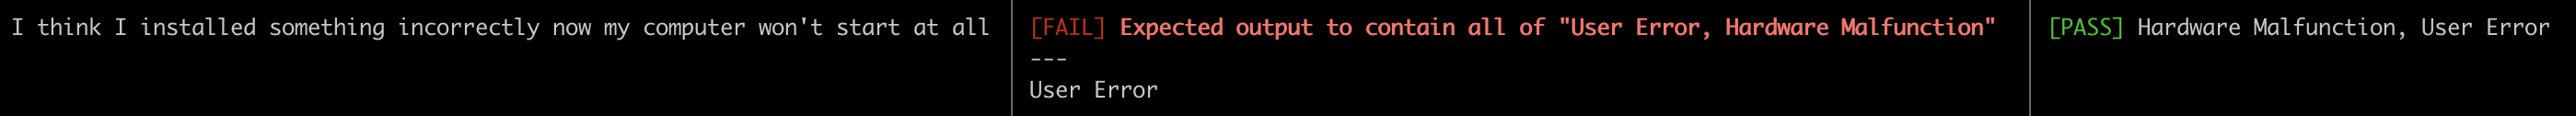

As always, we can also open up an interactive web of the evaluation results using this command:

```bash
npx promptfoo@latest view
```

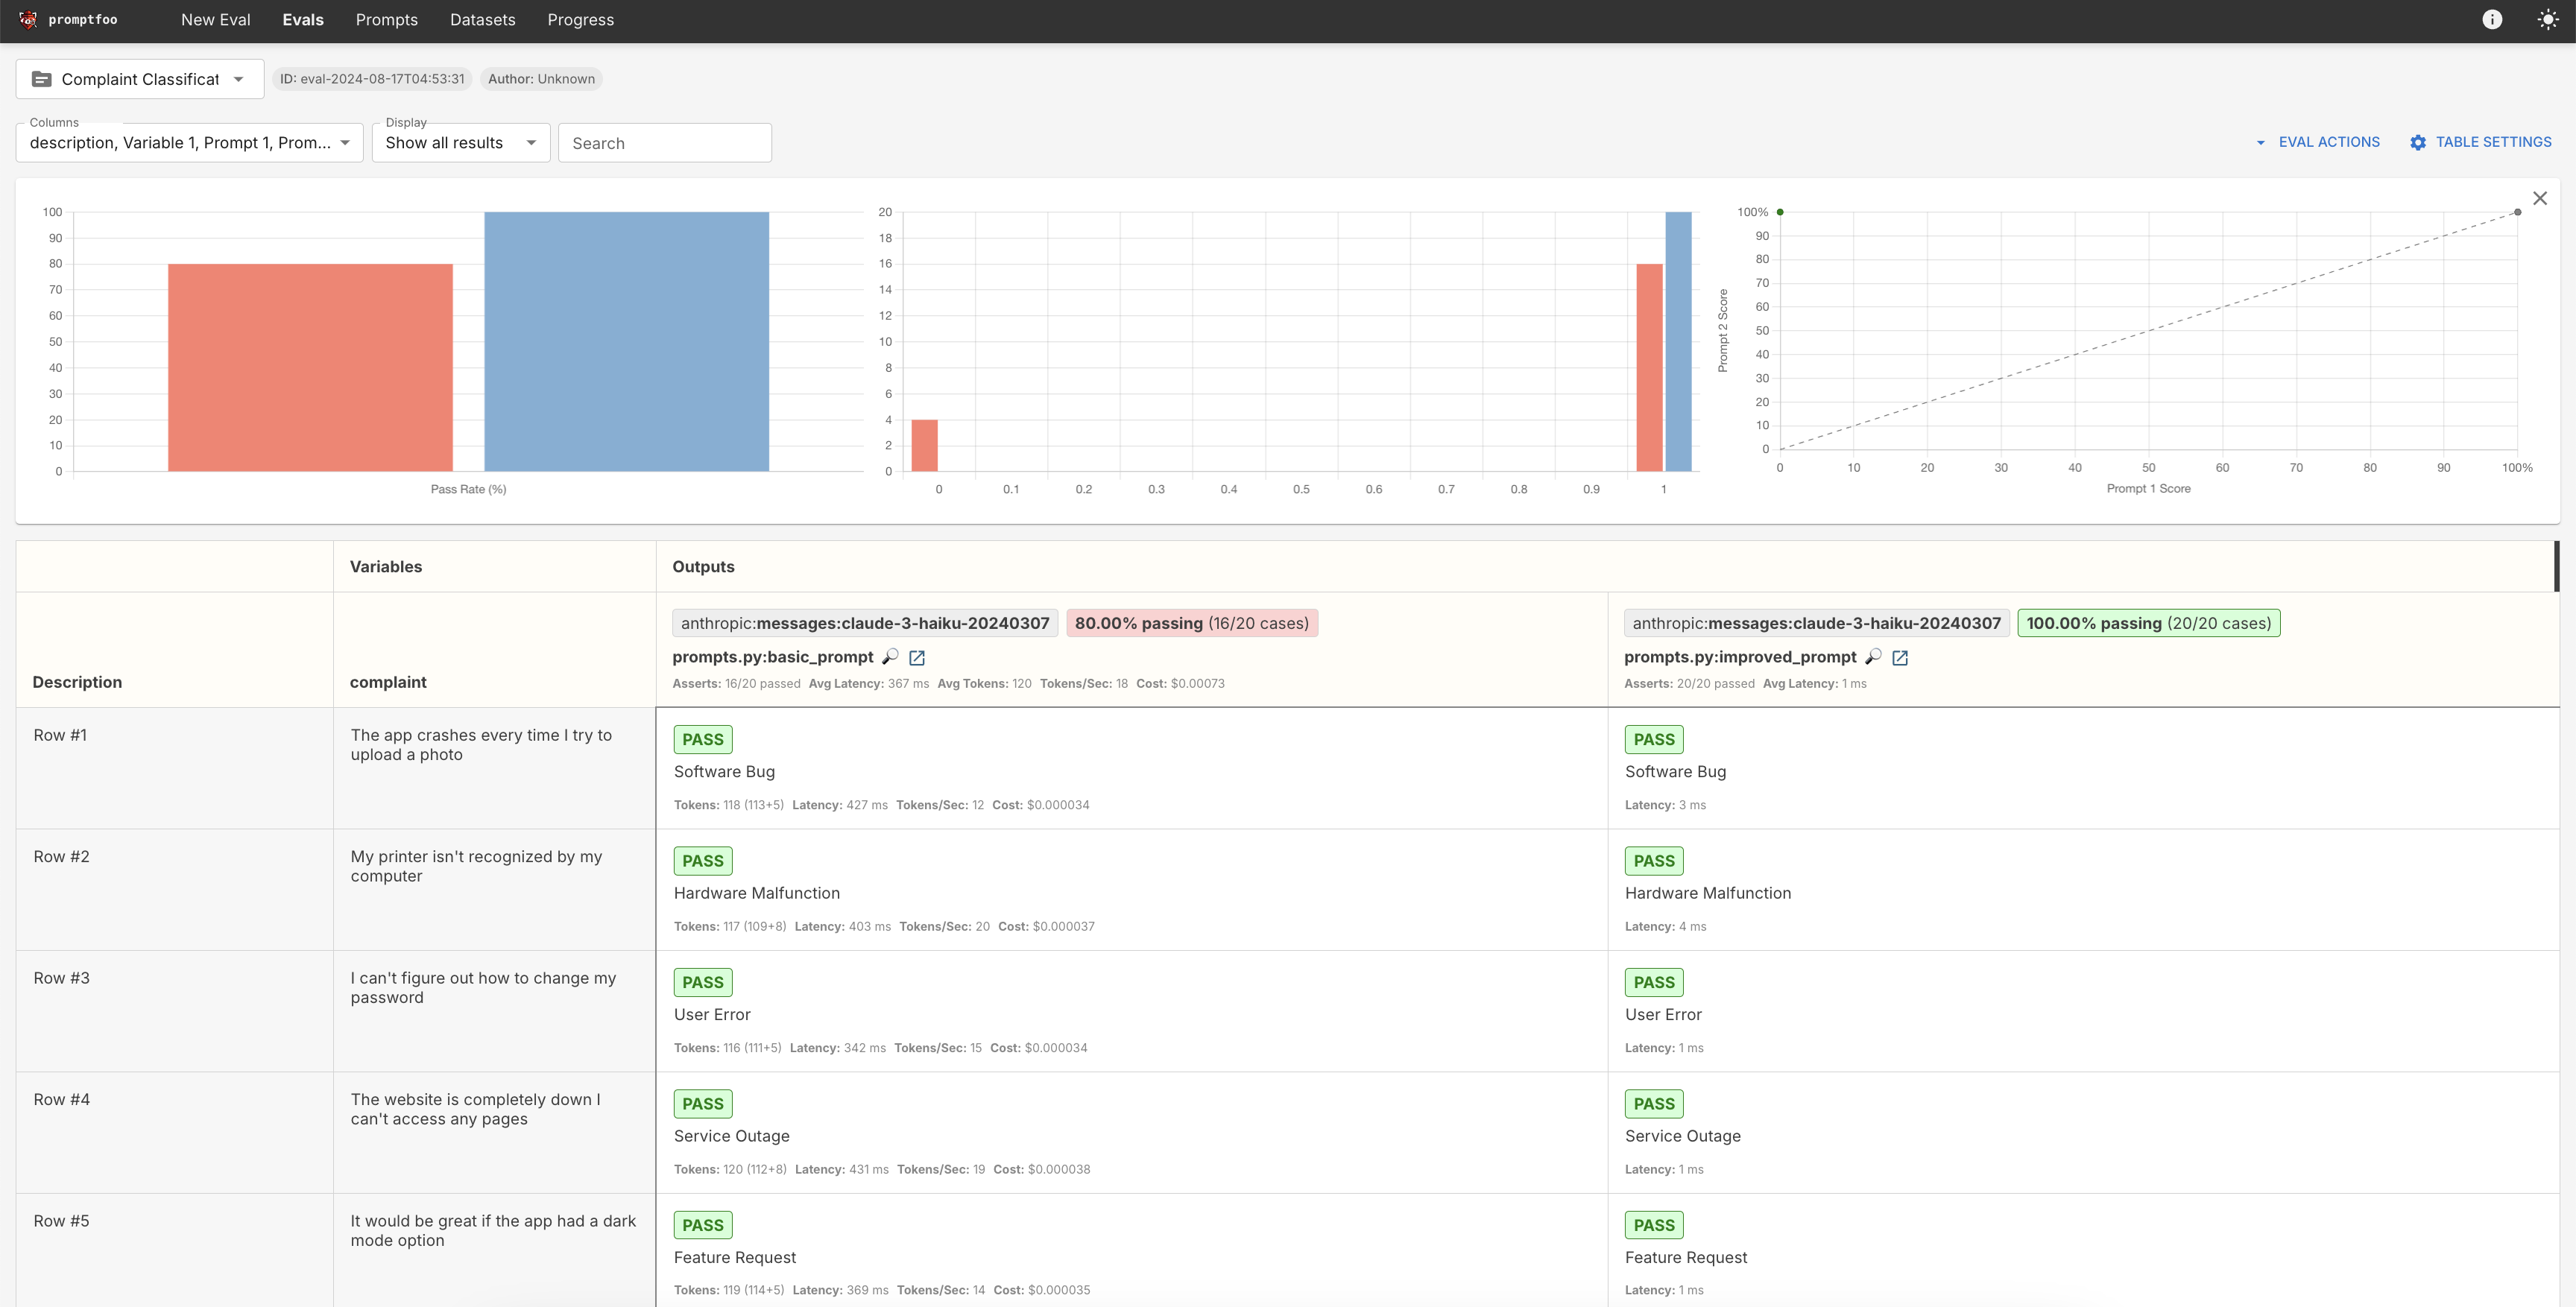

We can see that our `basic_prompt` got 80% right, while the `improved_prompt` scored 100%.

**As always, please remember that we are using small, educational datasets that are not representative of real-world evaluations.  We always recommend at least 100 rows in an evaluation dataset.**

Next up, we'll take a look at writing custom grading logic in promptfoo!